In [ ]:
#Catatan hari ini bahwa kita memeaki scikit learn untuk menamai Document
#Disini kita akan menggunkaan masing-masing file untuk dinami dengan menggunkaan TF-IDF
#Kita coba lahgi

d:\Semester_9_Keramat\Codingan\NLP_Word2Vec\word2vec_venv\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


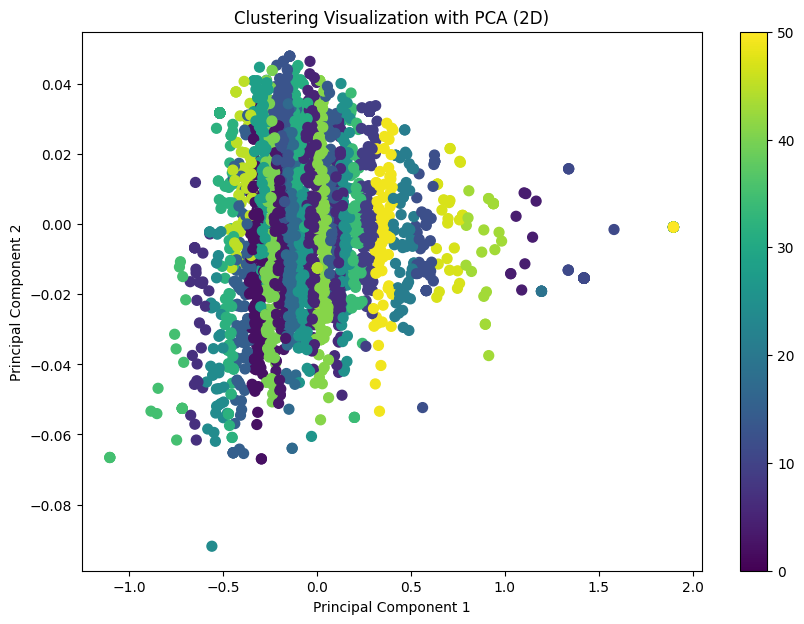

In [1]:
#Instalasi yang diperlukan
# gensim, nltk, scikit-learn, pandas, matplotlib

import os
import random
import re
import string

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec, KeyedVectors
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
import numpy as np
np.warnings = warnings

import joblib

from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

analyzer = SentimentIntensityAnalyzer()

# Seed for reproducibility
SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

# Load data and model
data = pd.read_excel('mie_gaga_english.xlsx')
# Download and define stopwords
stop_words = set(stopwords.words('english'))

#Melakukan cleaning data
def clean_text(text):
    """Pre-process text and generate tokens"""
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]  # Remove stopwords
    text = [word for word in text if len(word) >1]
    return text

data['clean_comment'] = data['comment'].apply(clean_text)

model = Word2Vec(data['clean_comment'], vector_size=50, window=4, min_count=5, seed=SEED)

def comment_to_vector(comment, model):
    """Generate average vector from the words in the comment"""
    valid_words = [word for word in comment if word in model.wv.index_to_key]
    
    if not valid_words:
        return np.zeros(model.vector_size)
    
    return np.mean([model.wv[word] for word in valid_words], axis=0)

data['vector'] = data['clean_comment'].apply(lambda x: comment_to_vector(x, model))

# Mengambil vektor untuk clustering
vectors = data['vector'].tolist()

#Disini adalah codingan untuk menghapus review yang tidak memiliki #product feature shingga clusteringnya lebih jelas
# Function to get sentiment score
def vader(text):
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score

# Assuming 'data' is your DataFrame and 'comment' is the column with text data
data['vader_score'] = data['comment'].apply(lambda x: vader(x)['compound'])
data=data[data['vader_score']!=0]
product_features = [
    # Core Product Features
    'product_item', 'product_items',
    'good', 'goods',
    'noodle', 'noodles',
    'taste', 'tastes', 'flavor', 'flavors', 'savor', 'savory',
    'spicy', 'spiciness', 'heat', 'hotness',
    'price', 'prices', 'cost', 'costs', 'value', 'worth',
    'promo', 'promos', 'discount', 'discounts', 'offer', 'offers',
    'delivery', 'deliveries', 'shipping', 'shipment', 'dispatch', 'dispatches',
    'packaging', 'packages', 'pack', 'packs', 'wrapper', 'wrappers',
    'response', 'responses', 'feedback', 'comment', 'comments', 'review', 'reviews',

    # Additional Relevant Terms
    'quality', 'qualities',
    'quantity', 'quantities', 'amount', 'amounts', 'portion', 'portions', 'serving', 'servings',
    'texture', 'textures', 'consistency', 'crisp', 'crispiness', 'chewiness', 'softness',
    'ingredient', 'ingredients', 'component', 'components', 'material', 'materials',
    'brand', 'brands', 'label', 'labels', 'trademark', 'trademarks',
    'nutrient', 'nutrients', 'nutrition', 'calorie', 'calories',
    'appearance', 'look', 'looks', 'design', 'designs', 'style', 'styles', 'aesthetic', 'aesthetics',
    'availability', 'stock', 'stocks', 'supply', 'supplies',
    'expiration', 'expiry', 'expiration_date', 'expiry_date', 'shelf_life',
    'portion', 'sizes', 'serving', 'sizes','satisfaction', 'satisfactions', 'preference', 'preferences', 'demand', 'demands',
    'sauce', 'sauces', 'seasoning', 'seasonings', 'flavoring', 'flavorings',
    'brand', 'brands', 'competition', 'competitors', 'rival', 'rivals', 'alternative', 'alternatives',
    'advertisement', 'advertisements', 'marketing', 'promotion', 'promotions',
    'popular', 'trend', 'trends', 'fame', 'recognition',
    'ease', 'convenience', 'quickness', 'speed', 'efficiency',
    'customer_service', 'customer_support', 'service', 'support',
    'availability', 'accessibility', 'distribution', 'reach',
    'packaging_design', 'brand_identity', 'product_variation', 'flavor', 'flavors']

# Fungsi untuk mengekstraksi kata benda
def extract_nouns(text):
    tagged_words = nltk.pos_tag(text)
    nouns = [word for word, pos in tagged_words if pos in ('NN', 'NNS', 'NNP', 'NNPS')]  # POS tags untuk noun
    return nouns

# Menggunakan fungsi untuk menambahkan kolom 'nouns'
data['nouns'] = data['clean_comment'].apply(extract_nouns)
# Filter data di mana 'clean_comment' ada dalam 'product_features' atau 'nouns' tidak kosong
data = data[data['clean_comment'].isin(product_features) | data['nouns'].apply(lambda x: len(x) > 0)]
vectors = np.array(data['vector'].tolist())

# Perform clustering using Affinity Propagation
ap = AffinityPropagation(random_state=SEED)
ap.fit(vectors)
labels = ap.labels_

# Add cluster labels to DataFrame
data['cluster'] = labels

# Save the DataFrame with clusters
joblib.dump(data, 'noun_apclustering_no_reduction.pkl')

# Optional: If you want to visualize, you can use PCA for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=SEED)
reduced_vectors_2d = pca.fit_transform(vectors)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_vectors_2d[:, 0], reduced_vectors_2d[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar()
plt.title('Clustering Visualization with PCA (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
#identifikasi ap clusering
#mencari kluster yang lebih dari 90
cluster_count = data.value_counts(subset='cluster')
data_keep = cluster_count[cluster_count>90].index

#mikir bentar
filtered_data = data[data['cluster'].isin(data_keep)]
filtered_data.drop('vector',axis=1).to_csv('coba.csv')
cluster_cek = filtered_data.value_counts(subset='cluster')
for i in draft['cluster']:
    cluster=data[data['cluster']==i]
    cluster=cluster_371.drop(columns=['star'])

for cluster_id in data['cluster']:
    # Ambil semua dokumen dalam cluster tertentu
    cluster_data = data[data['cluster'] == cluster_id]
    
    # Gabungkan kembali clean_comment (list of words) ke dalam bentuk string
    cluster_texts = cluster_data['clean_comment'].apply(lambda x: ' '.join(x))
    cluster_texts.isna()



In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Membuat dictionary untuk menyimpan TF-IDF hasil per cluster
tfidf_cluster_results = {}

# Iterasi setiap cluster yang sudah terbentuk
for cluster_id in data['cluster']:
    # Ambil semua dokumen dalam cluster tertentu
    cluster_data = data[data['cluster'] == cluster_id]
    
    # Gabungkan kembali clean_comment (list of words) ke dalam bentuk string
    cluster_texts = cluster_data['clean_comment'].apply(lambda x: ' '.join(x))
    
    # Hitung TF-IDF untuk dokumen di dalam cluster ini
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(cluster_texts.split('\n'))
    
    # Menyimpan hasil dalam dictionary
    tfidf_cluster_results[cluster_id] = pd.DataFrame(tfidf_matrix.toarray(), 
                                                     columns=vectorizer.get_feature_names_out())
    
    # Menampilkan hasil TF-IDF untuk cluster ini
    print(f"TF-IDF for Cluster {cluster_id}:")
    print(tfidf_cluster_results[cluster_id].head())  # Print beberapa baris pertama dari hasil TF-IDF

# Menyimpan hasil TF-IDF setiap cluster ke dalam file CSV
for cluster_id, tfidf_df in tfidf_cluster_results.items():
    tfidf_df.to_csv(f'tfidf_cluster_{cluster_id}.csv', index=False)

# Function to extract the top N words based on TF-IDF
def get_top_n_words(tfidf_df, n=5):
    """Get the top N words with the highest TF-IDF score"""
    top_n_words = tfidf_df.mean().sort_values(ascending=False).head(n).index.tolist()
    return top_n_words

# Mencari kata benda dengan TF-IDF tertinggi untuk setiap cluster
top_n_words_per_cluster = {}
for cluster_id, tfidf_df in tfidf_cluster_results.items():
    nouns_in_cluster = data[data['cluster'] == cluster_id]['nouns'].sum()
    
    # Filter TF-IDF dataframe hanya untuk kata benda (nouns)
    tfidf_nouns = tfidf_df[[word for word in tfidf_df.columns if word in nouns_in_cluster]]
    
    # Mendapatkan kata benda dengan TF-IDF tertinggi
    top_n_words = get_top_n_words(tfidf_nouns)
    top_n_words_per_cluster[cluster_id] = top_n_words
    
    # Menampilkan kata benda dengan bobot TF-IDF tertinggi untuk cluster ini
    print(f"Cluster {cluster_id}: Top Nouns with Highest TF-IDF")
    print(top_n_words)




AttributeError: 'Series' object has no attribute 'split'